# Disociační křivka molekulárního vodíku - celá
V tomto notebooku je ukázka výpočtu disociační křivky molekulárního vodíku při použití bazického souboru 6-31G. Voleno zde bude paritní mapování u kterého je ze znalosti symetrií možné odstranit 2 ze 4 qubitů a urychlit tak výpočet. Výpočet dále urychlíme též využitím tzv. bootstrappingu, kdy vzorkovač (BOPES) využívá optimálních variačních parametrů daného stupně volnosti jako počátečních bodů pro VQE v dalších stupních volnosti.

In [1]:
#version control
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.0', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.0', 'qiskit-nature': '0.4.3', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# import qiskit tools
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE

# improt qiskit nature tools
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.algorithms.pes_samplers import BOPESSampler

import warnings

warnings.simplefilter("ignore", np.RankWarning)

algorithm_globals.random_seed = 75

Jako klasický driver volíme Psi4 a jako bazický soubor 6-31G.

In [3]:
#define the distance which will be regarded as a degree of freedom
distance = partial(Molecule.absolute_distance, atom_pair=(1, 0))

#define the molecule
molecule = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance],
)

# pass molecule to PSI4 driver with sto3g basis
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="6-31g", driver_type=ElectronicStructureDriverType.PSI4
)

Zde můžeme vidět, jak vypadá fermionový operátor v druhém kvantování:

In [4]:
#define eloctronic structure problem
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=8, number terms=528
  -1.6354187225929817 * ( +_0 -_0 )
+ -0.21531189509470797 * ( +_0 -_2 )
+ -0.4677371911218105 * ( +_1 -_1 )
+ -0.2077838530542889 * ( +_1 -_3 )
+ -0.21531189509470794 * ( +_2 -_0 )
+ -0.409726538 ...


V tomto případě pro názornost použijeme vzhledem k již zmíněným výhodám paritní mapování s redukcí počtu qubitů mapování:

In [5]:
#Parity mapping with reduction
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
print(qubit_op)

2.0489637661958287 * IIIIII
- 0.23987258067264663 * IIIIIZ
- 0.08289254060917933 * IIIZXX
- 0.08289254060917933 * IIIIYY
- 0.4301236155125804 * IIIIZZ
+ 0.02799636295717553 * IIIXXZ
- 0.027996362957175676 * IIIYYI
- 0.5883567403032337 * IIIZZI
+ 1.5701859171820054 * IIIZII
+ 0.23987258067264522 * IIZIII
+ 0.08289254060917892 * ZXXIII
- 0.08289254060917933 * IYYIII
- 0.4301236155125804 * IZZIII
- 0.027996362957175842 * XXZIII
- 0.0279963629571757 * YYIIII
- 0.5883567403032338 * ZZIIII
- 1.5701859171820214 * ZIIIII
- 0.030208314465065465 * IIIIZI
- 0.03778572161994619 * IIIXXI
+ 0.03778572161994618 * IIIYYZ
+ 0.01502194189841724 * IIIZZZ
- 0.09633006500430422 * IIIZIZ
- 0.04943166591946216 * IIIZYY
- 0.04943166591946216 * IIIIXX
- 0.21543966888460414 * IIZIIZ
- 0.05382797363380286 * IIZZXX
- 0.05382797363380286 * IIZIYY
- 0.00950339942100169 * IZXIZX
- 0.009503399421001738 * IIXIZX
+ 0.00950339942100169 * IZXIIX
+ 0.009503399421001738 * IIXIIX
+ 0.015216350157807248 * IZXXXX
+ 0.01521635

V dalším definujeme úlohu a jako backend použijeme StatevectorSimulator.

In [6]:
#define quantum instance (using statevector simulator)
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)
gsc = GroundStateEigensolver(qubit_converter, solver)

Úlohu budeme počítat v 10 ekvidistantně rozmístěných bodech pro vzdálenosti jader v rozmezí 0,2 až 2 Ångströmy. Ke vzorkování se použije třída BOPESSampler sloužící k vyhodnocení PES při Born-Oppenheimrově aproximaci. Bootstrapping volíme jako True.

In [7]:
# Specify degree of freedom (points of interest)
points = np.linspace(0.2, 2, 10) #equidistantly distributes 10 points in given range
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition

# define instance to sampler
bs = BOPESSampler(gsc, bootstrap=True, num_bootstrap=None, extrapolator=None)

# execute
res = bs.sample(es_problem, points)
results_full[f"VQE"] = res.raw_results
results[f"points_"] = res.points
results[f"energies_"] = res.energies

Pro srovnání použijeme klasické řešení:

In [8]:
#compare to classical eigensolver
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None)

# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

Energie v jednotlivých bodech z VQE:

In [9]:
print(results[f"energies_"])

[0.07240312808505278, -0.9428885632464352, -1.1228711203229338, -1.1405381223642903, -1.1177285627590985, -1.0873666029571845, -1.0597557157521087, -1.0368728104394767, -1.0197986279917544, -1.0088813471936389]


Energie v jednotlivých bodech klasicky:

In [10]:
print(results["energies_np"])

[0.06516888326115078, -0.950678655192025, -1.1319534598304313, -1.1500278813935036, -1.1267783525475017, -1.0955954890043442, -1.0667752736950034, -1.043431819152128, -1.0261357176987371, -1.0143102746687036]


Výsledky vykreslíme v grafu:

Text(0, 0.5, 'Energy')

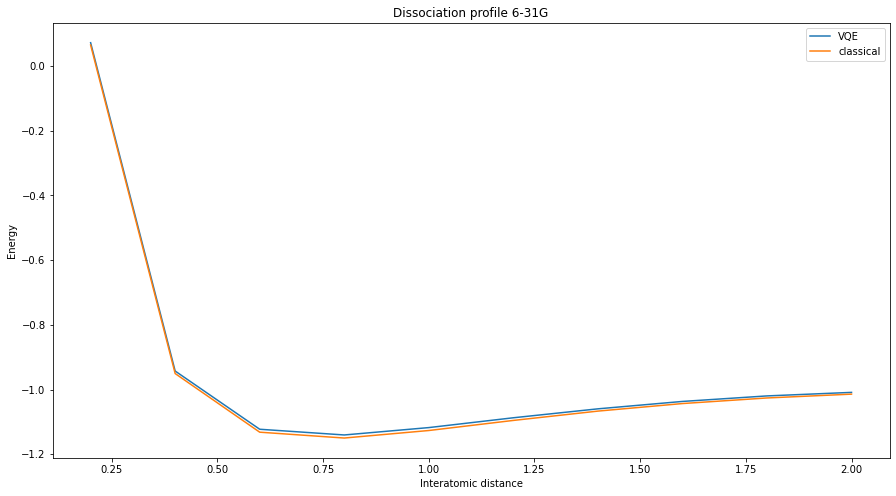

In [14]:
fig = plt.figure(figsize=(15, 8))

plt.plot(results[f"points_"], results[f"energies_"], label=f"VQE")
plt.plot(results["points_np"], results["energies_np"], label="classical")
plt.legend()
plt.title("Dissociation profile 6-31G")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

Je vidět, že výsledky VQE na této škále dobře souhlasí s klasickými, křivky se téměř překrývají. Proto se v dalších výpočtech budeme soustředit na velmi úzkou oblast vzdáleností jader, kde budou rozdíly mezi klasickým řešením a VQE patrnější.
Zde se ještě můžeme podívat, kolik bylo pro tento výpočet potřeba vyhodnocení VQE (při použití bootstrap).

In [12]:
for condition, result_full in results_full.items():
    if condition != "np":
        print("Total evaluations: ")
        sum = 0
        for key in result_full:
            sum += result_full[key].raw_result.cost_function_evals  
        else:
            continue
    print(sum)

Total evaluations: 
4089


In [13]:
# This code is a modification of Qiskit code licensed under the Apache License, Version 2.0.